In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import scanpy.external as sce
import scvi
from scvi.model import CondSCVI, DestVI
import torch
from scvi.external import RNAStereoscope, SpatialStereoscope
import matplotlib.pyplot as plt

The history saving thread hit an unexpected error (OperationalError('no such table: history')).History will not be written to the database.


In [103]:
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, frameon=True, figsize=(3, 3), transparent=True, format="pdf")
sc.settings.verbosity = 3

-----
anndata     0.7.5
scanpy      1.8.1
sinfo       0.3.1
-----
PIL                 8.1.1
absl                NA
anndata             0.7.5
anyio               NA
argon2              20.1.0
asciitree           NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2021.05.30
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.3.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dask                2021.02.0
dateutil            2.8.1
decorator           4.4.2
deprecate           0.3.0
fasteners           NA
fsspec              2021.05.0
future_fstrings     NA
google              NA
h5py                2.10.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsons

In [104]:
samples = ['Mock-Heart-D4PI', 'T1L-Heart-D4PI', 'Mock-Heart-D7PI', 'T1L-Heart-D7PI']

In [105]:
heart_infection_sc_no_viral_genes = sc.read_h5ad('./../pyobjs/heart_infection_sc_raw_counts.h5ad')
heart_infection_sc_no_viral_genes.layers["counts"] = heart_infection_sc_no_viral_genes.X.copy()
heart_infection_sc_no_viral_genes.obs = sc.read_h5ad("./../pyobjs/heart_infection_sc.h5ad").obs
heart_infection_sc_no_viral_genes

AnnData object with n_obs × n_vars = 31684 × 22757
    obs: 'sample', 'T1LReoS1', 'T1LReoS2', 'T1LReoS3', 'T1LReoS4', 'T1LReoM1', 'T1LReoM2', 'T1LReoM3', 'T1LReoL1', 'T1LReoL2', 'T1LReoL3', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_viral', 'pct_viral', 'stage', 'state', 'condition', 'n_genes', 'S_score', 'G2M_score', 'phase', 'umap_density_condition', 'leiden_0.8', 'leiden_0.5', 'leiden_0.3', 'leiden_0.1', 'celltypes_leiden_0.3', 'celltypes_leiden_0.5', 'leiden_0.4', 'leiden_0.45', 'celltype_groups'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'condition_colors'
    layers: 'counts'

In [106]:
sc.pp.normalize_total(heart_infection_sc_no_viral_genes, target_sum=10e4)
sc.pp.log1p(heart_infection_sc_no_viral_genes)
sc.pp.highly_variable_genes(heart_infection_sc_no_viral_genes, max_mean=3.0, min_disp=0.5)
heart_infection_sc_no_viral_genes.raw = heart_infection_sc_no_viral_genes
heart_infection_sc_no_viral_genes = heart_infection_sc_no_viral_genes[:, heart_infection_sc_no_viral_genes.var.highly_variable]
print(heart_infection_sc_no_viral_genes.shape)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:08)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/mm2937/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(31684, 3886)


In [111]:
stage_data_visium = list()

for sample in samples:
    print(sample)
    data_visium = sc.read_visium(path="./../spatialData/" + sample + "/outs/")
    data_visium.var_names_make_unique()
    print(data_visium)
    
    reoviral_genes = [name for name in data_visium.var_names if name.startswith('Reo')]
    print(reoviral_genes)
    viral_expression = data_visium[:,reoviral_genes].to_df()
    viral_expression.columns = [x.split("_")[1] for x in viral_expression.columns]
    reoviral_genes_indicator = np.in1d(data_visium.var_names, reoviral_genes)
    data_visium_no_viral_genes = data_visium[:, ~reoviral_genes_indicator]
    data_visium_no_viral_genes.var_names = [name.split("_")[1] for name in data_visium_no_viral_genes.var_names]
    data_visium_no_viral_genes.obs.join(viral_expression.astype(int))
    print(data_visium_no_viral_genes.shape)

    data_visium_no_viral_genes.obs_names_make_unique()
    data_visium_no_viral_genes.var_names_make_unique()

    sc.pp.filter_cells(data_visium_no_viral_genes, min_counts=1)
    sc.pp.filter_genes(data_visium_no_viral_genes, min_cells=1)

    data_visium_no_viral_genes.var['mt'] = data_visium_no_viral_genes.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(data_visium_no_viral_genes, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

    data_visium_no_viral_genes.layers["counts"] = data_visium_no_viral_genes.X.copy()
    
    sc.pp.normalize_total(data_visium_no_viral_genes, target_sum=10e4)
    sc.pp.log1p(data_visium_no_viral_genes)

    data_visium_no_viral_genes.raw = data_visium_no_viral_genes    
    stage_data_visium.append(data_visium_no_viral_genes)

Mock-Heart-D4PI
reading ../spatialData/Mock-Heart-D4PI/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 1835 × 54848
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
['ReoT1L_T1LReoS1', 'ReoT1L_T1LReoS2', 'ReoT1L_T1LReoS3', 'ReoT1L_T1LReoS4', 'ReoT1L_T1LReoM1', 'ReoT1L_T1LReoM2', 'ReoT1L_T1LReoM3', 'ReoT1L_T1LReoL1', 'ReoT1L_T1LReoL2', 'ReoT1L_T1LReoL3']
(1835, 54838)
filtered out 36181 genes that are detected in less than 1 cells
normalizing counts per cell
    finished (0:00:00)
T1L-Heart-D4PI
reading ../spatialData/T1L-Heart-D4PI/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 1372 × 54848
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
['ReoT1L_T1LReoS1', 'ReoT1L_T1LReoS2', 'ReoT1L_T1LReoS3', 'ReoT1L_T1LReoS4', 'ReoT1L_T1LReoM1', 'ReoT1L_T1LReoM2', 'ReoT1L_T1LReoM3', 'ReoT1L_T1LReoL1', 'ReoT1L_T1LReoL2', 'ReoT1L_T1LReoL3']
(1372, 54838)
filtered out 37333 genes that are detected in less than 1 cells
normalizing counts per cell
    finished (0:00:00)
Mock-Heart-D7PI
reading ../spatialData/Mock-Heart-D7PI/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 2758 × 54848
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
['ReoT1L_T1LReoS1', 'ReoT1L_T1LReoS2', 'ReoT1L_T1LReoS3', 'ReoT1L_T1LReoS4', 'ReoT1L_T1LReoM1', 'ReoT1L_T1LReoM2', 'ReoT1L_T1LReoM3', 'ReoT1L_T1LReoL1', 'ReoT1L_T1LReoL2', 'ReoT1L_T1LReoL3']
(2758, 54838)
filtered out 36492 genes that are detected in less than 1 cells
normalizing counts per cell
    finished (0:00:00)
T1L-Heart-D7PI
reading ../spatialData/T1L-Heart-D7PI/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 2278 × 54848
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
['ReoT1L_T1LReoS1', 'ReoT1L_T1LReoS2', 'ReoT1L_T1LReoS3', 'ReoT1L_T1LReoS4', 'ReoT1L_T1LReoM1', 'ReoT1L_T1LReoM2', 'ReoT1L_T1LReoM3', 'ReoT1L_T1LReoL1', 'ReoT1L_T1LReoL2', 'ReoT1L_T1LReoL3']
(2278, 54838)
filtered out 36885 genes that are detected in less than 1 cells
normalizing counts per cell
    finished (0:00:00)


In [72]:
# for i, library in enumerate(stage_data_visium):
#     # filter genes to be the same on the spatial data
#     intersect = np.intersect1d(heart_infection_sc_no_viral_genes.var_names, library.var_names)
#     G = len(intersect)
#     print(G)
#     library = library[:, intersect].copy()
#     heart_infection_sc_no_viral_genes = heart_infection_sc_no_viral_genes[:, intersect].copy()

In [123]:
T1L_heart_D7PI_visium_no_viral_genes = stage_data_visium[3]
intersect = np.intersect1d(heart_infection_sc_no_viral_genes.var_names, T1L_heart_D7PI_visium_no_viral_genes.var_names)
print(len(intersect))
T1L_heart_D7PI_visium_no_viral_genes = T1L_heart_D7PI_visium_no_viral_genes[:, intersect].copy()
heart_infection_sc_no_viral_genes = heart_infection_sc_no_viral_genes[:, intersect].copy()

2482


/home/mm2937/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [124]:
scvi.data.setup_anndata(heart_infection_sc_no_viral_genes, layer="counts", labels_key="celltypes_leiden_0.5")

INFO     No batch_key inputted, assuming all cells are same batch                            


No batch_key inputted, assuming all cells are same batch


INFO     Using labels from adata.obs["celltypes_leiden_0.5"]                                 


Using labels from adata.obs["celltypes_leiden_0.5"]


INFO     Using data from adata.layers["counts"]                                              


/home/mm2937/miniconda3/envs/python385/lib/python3.8/site-packages/scvi/data/_anndata.py:729: UserWarning: Category 6 in adata.obs['_scvi_labels'] has fewer than 3 cells. SCVI may not train properly.
  warnings.warn(
Using data from adata.layers["counts"]


INFO     Computing library size prior per batch                                              


Computing library size prior per batch


INFO     Successfully registered anndata object containing 5086 cells, 2482 vars, 1 batches, 
         18 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        


/home/mm2937/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Successfully registered anndata object containing 5086 cells, 2482 vars, 1 batches, 18 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


Please do not further modify adata until model is trained.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 200/200: 100%|██████████| 200/200 [00:42<00:00,  4.67it/s, loss=547, v_num=1]   


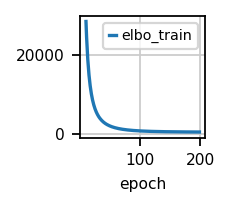

In [125]:
# sc_model = CondSCVI(heart_infection_sc_no_viral_genes)
# sc_model = CondSCVI(heart_infection_sc_no_viral_genes, weight_obs=True)
# sc_model.train(max_epochs=250)
# sc_model.history["elbo_train"].plot()
train = True
if train:
    sc_model = RNAStereoscope(heart_infection_sc_no_viral_genes)
    sc_model.train(max_epochs = 200)
    sc_model.history["elbo_train"][10:].plot()
    sc_model.save("scmodel", overwrite=True)
else:
    sc_model = RNAStereoscope.load("scmodel", heart_infection_sc_no_viral_genes)
    print("Loaded RNA model from file!")

In [126]:
# for i, library in enumerate(stage_data_visium):
#     # filter genes to be the same on the spatial data
#     intersect = np.intersect1d(heart_infection_sc_no_viral_genes.var_names, library.var_names)
#     G = len(intersect)
#     print(G)
#     library = library[:, intersect].copy()
#     heart_infection_sc_no_viral_genes = heart_infection_sc_no_viral_genes[:, intersect].copy()
#     scvi.data.setup_anndata(library, layer="counts")

In [127]:
scvi.data.setup_anndata(T1L_heart_D7PI_visium_no_viral_genes, layer="counts")

INFO     No batch_key inputted, assuming all cells are same batch                            


No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                           


No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["counts"]                                              


Using data from adata.layers["counts"]


INFO     Computing library size prior per batch                                              


Computing library size prior per batch


INFO     Successfully registered anndata object containing 2278 cells, 2482 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/home/mm2937/miniconda3/envs/python385/lib/python3.8/site-packages/scvi/data/_utils.py:22: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  warnings.warn(
Successfully registered anndata object containing 2278 cells, 2482 vars, 1 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


Please do not further modify adata until model is trained.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 1500/1500: 100%|██████████| 1500/1500 [03:09<00:00,  7.93it/s, loss=9.22e+05, v_num=1]


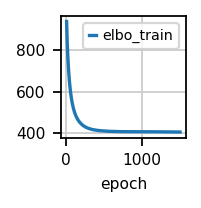

In [128]:
# st_model = DestVI.from_rna_model(T1L_heart_D7PI_visium_no_viral_genes, sc_model)
# st_model.train(max_epochs=2000)
# st_model.history["elbo_train"].plot()
train=True
if train:
    spatial_model = SpatialStereoscope.from_rna_model(T1L_heart_D7PI_visium_no_viral_genes, sc_model)
    spatial_model.train(max_epochs = 1500)
    spatial_model.history["elbo_train"][10:].plot()
    spatial_model.save("stmodel", overwrite = True)
else:
    spatial_model = SpatialStereoscope.load("stmodel", st_adata)
    print("Loaded Spatial model from file!")

In [129]:
T1L_heart_D7PI_visium_no_viral_genes.obsm["proportions"] = spatial_model.get_proportions()

In [130]:
ct_list = T1L_heart_D7PI_visium_no_viral_genes.obsm["proportions"].columns
for ct in ct_list:
    data = T1L_heart_D7PI_visium_no_viral_genes.obsm["proportions"][ct].values
    T1L_heart_D7PI_visium_no_viral_genes.obs[ct] = np.clip(data, 0, np.quantile(data, 0.99))
    
T1L_heart_D7PI_visium_no_viral_genes.obs["max_pred"] = T1L_heart_D7PI_visium_no_viral_genes.obsm["proportions"][ct_list].max(axis=1)
T1L_heart_D7PI_visium_no_viral_genes.obs["max_pred_celltype"] = T1L_heart_D7PI_visium_no_viral_genes.obsm["proportions"][ct_list].idxmax(axis=1)

... storing 'max_pred_celltype' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


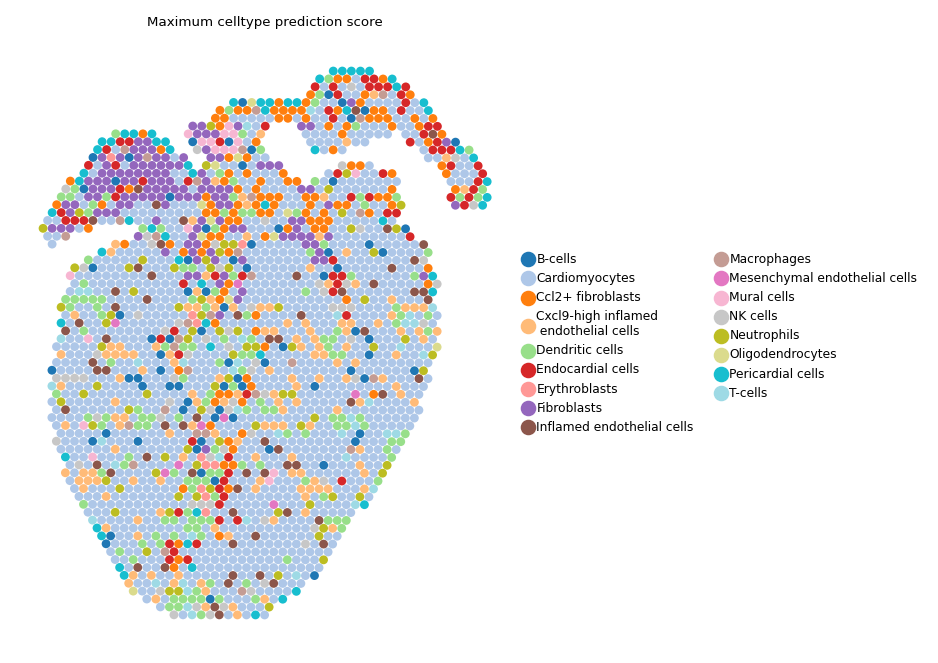

In [131]:
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, frameon=True, figsize=(5, 5), transparent=True, vector_friendly = False, format="pdf")
sc.pl.spatial(
        T1L_heart_D7PI_visium_no_viral_genes,
        img_key="hires",
        color=["max_pred_celltype"],
        show=True, 
        frameon=False,
        palette="tab20",
        title="Maximum celltype prediction score",
        size=1.5, scale_factor=1.0)

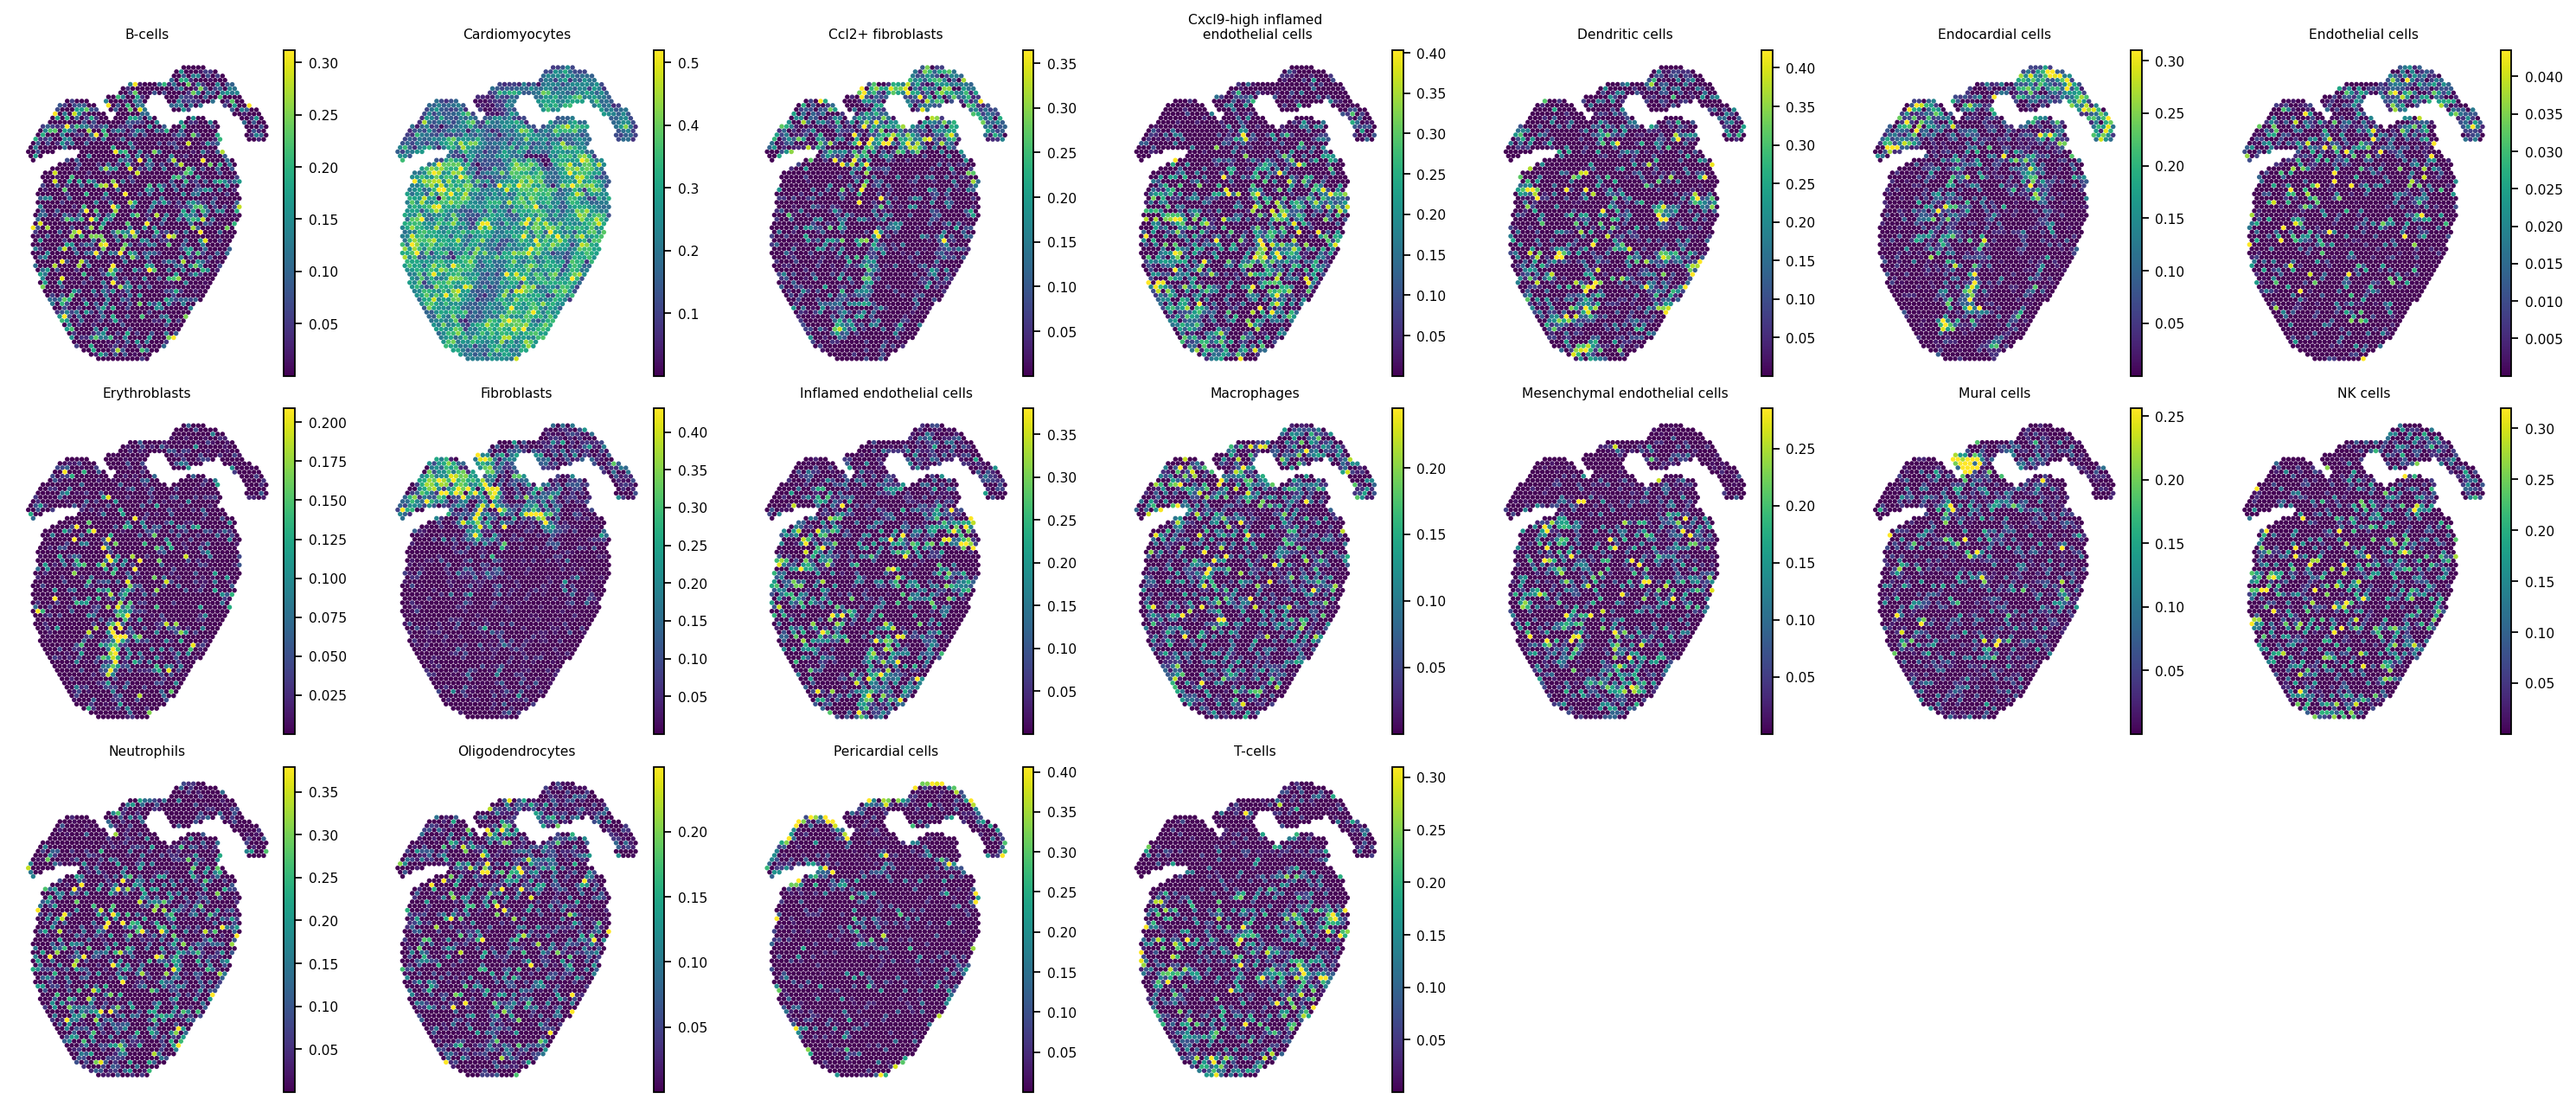

In [133]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=7, figsize=(3.0,3.0), facecolor='white', frameon=True, transparent=True, format="pdf")
sc.pl.spatial(T1L_heart_D7PI_visium_no_viral_genes, color=T1L_heart_D7PI_visium_no_viral_genes.obsm["proportions"].columns, ncols=7, frameon=False, 
              size=1.5, scale_factor=1.0, hspace=0.1, wspace=0.1)

In [ ]:
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, frameon=True, figsize=(2, 2), transparent=True, vector_friendly = False, format="pdf")
sc.pl.spatial(
        T1L_heart_D7PI_visium_no_viral_genes,
        img_key="hires",
        color=["max_pred_celltype"],
        show=True, 
        frameon=False,
        palette="tab20",
        title="Maximum celltype prediction score",
        size=1.5, scale_factor=1.0, save="day7_spatial_deconv.pdf")

In [ ]:
T1L_heart_D7PI_visium_no_viral_genes.obsm["proportions"].columns

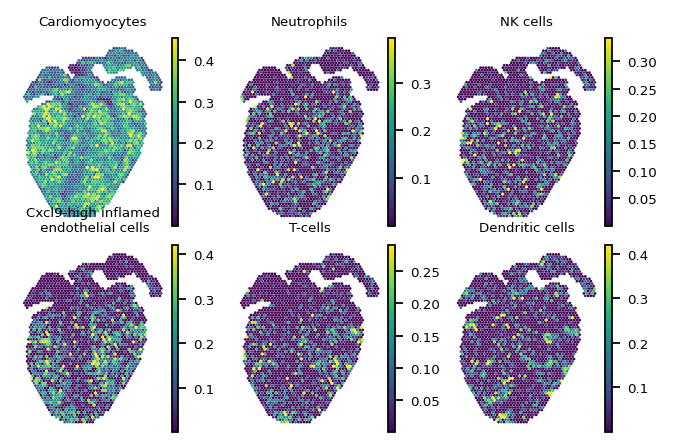

In [121]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=6, figsize=(1.5,1.5), facecolor='white', frameon=True, transparent=True, format="pdf")
sc.pl.spatial(T1L_heart_D7PI_visium_no_viral_genes, color=["Cardiomyocytes", "Neutrophils", "NK cells", "Cxcl9-high inflamed\n endothelial cells", "T-cells", "Dendritic cells"], ncols=3, frameon=False, 
              size=1.5, scale_factor=1.0, hspace=0.1, wspace=0.1, save="cell_comp_interest.pdf")

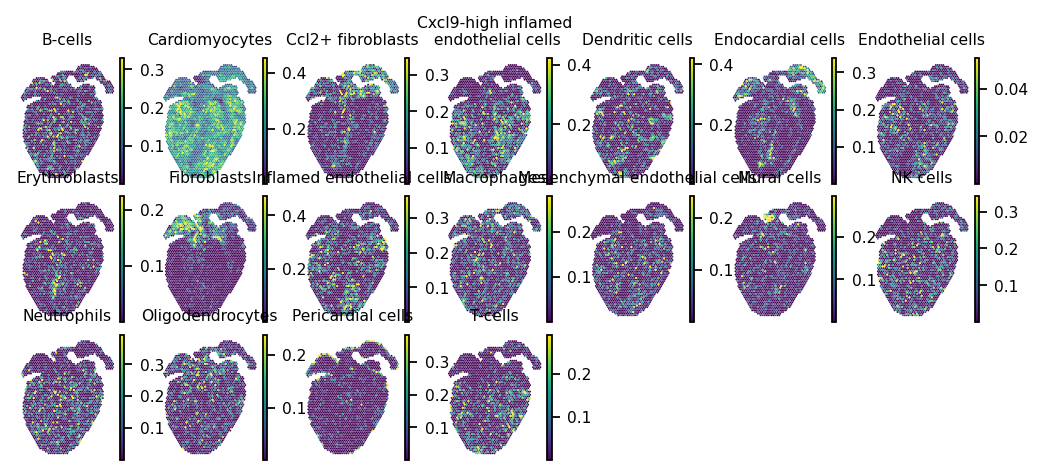

In [122]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=7, figsize=(1.0,1.0), facecolor='white', frameon=True, transparent=True, format="pdf")
sc.pl.spatial(T1L_heart_D7PI_visium_no_viral_genes, color=T1L_heart_D7PI_visium_no_viral_genes.obsm["proportions"].columns, ncols=7, frameon=False, 
              size=1.5, scale_factor=1.0, hspace=0.1, wspace=0.1, save="cell_comp.pdf")

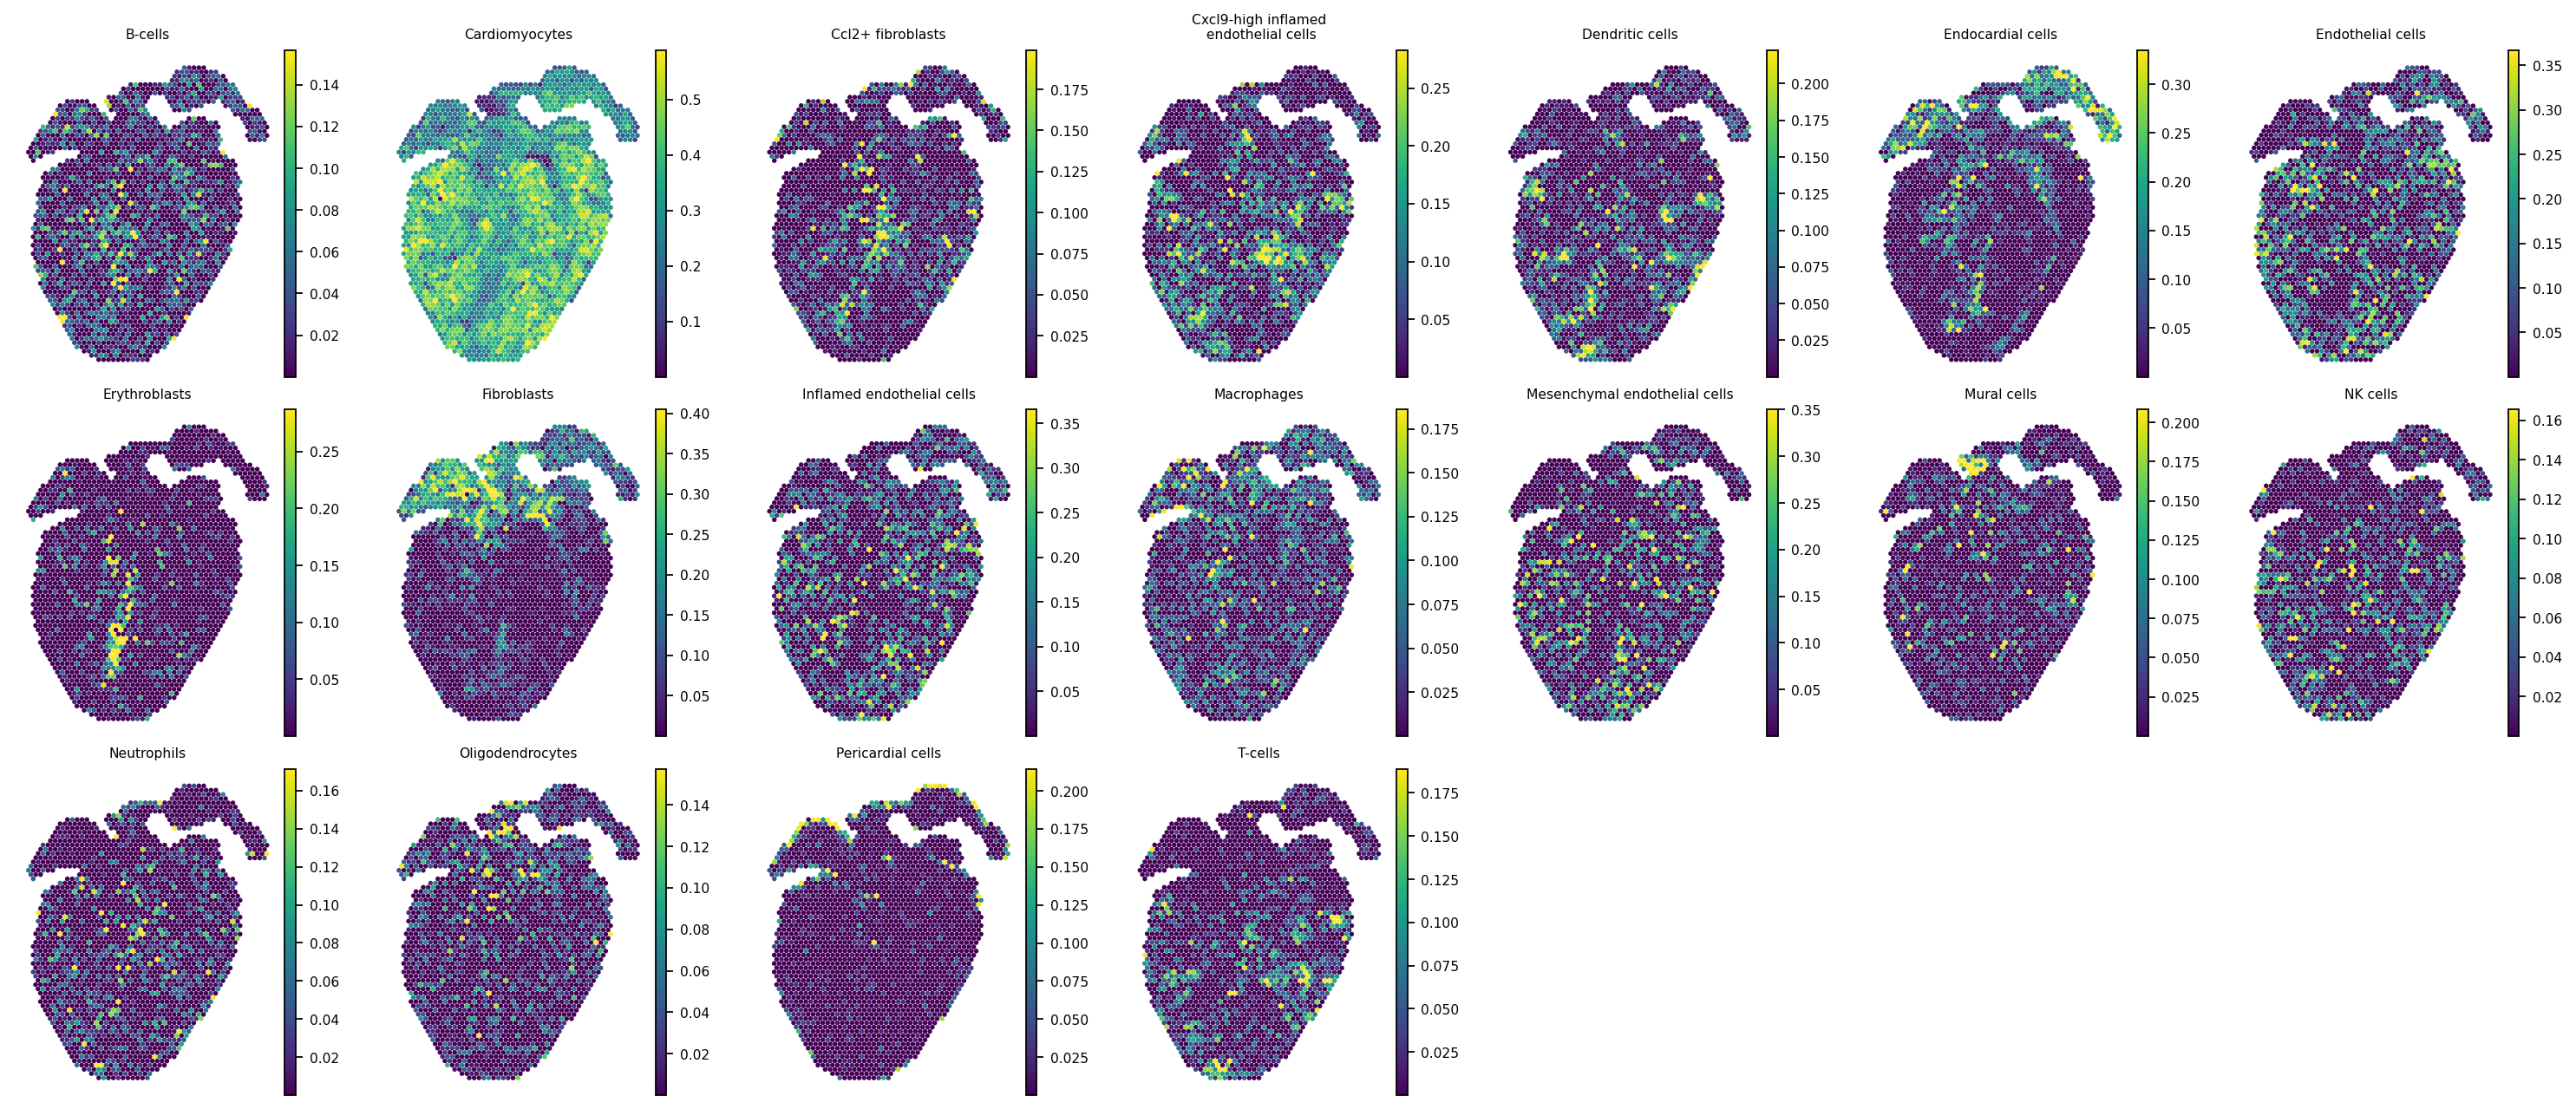

In [83]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=7, figsize=(3.0,3.0), facecolor='white', frameon=True, transparent=True, format="pdf")
sc.pl.spatial(T1L_heart_D7PI_visium_no_viral_genes, color=T1L_heart_D7PI_visium_no_viral_genes.obsm["proportions"].columns, ncols=7, frameon=False, 
              size=1.5, scale_factor=1.0, hspace=0.1, wspace=0.1)

In [ ]:
# T1L_heart_D7PI_visium_no_viral_genes.write_h5ad(filename="./../pyobjs/T1L_heart_D7PI_visium_no_viral_genes_composition_stereoscope_150_1500_celltypes_leiden_0.5.h5ad")

In [3]:
T1L_heart_D7PI_visium_no_viral_genes = sc.read_h5ad(filename="./../pyobjs/T1L_heart_D7PI_visium_no_viral_genes_composition_stereoscope_150_1500_celltypes_leiden_0.5.h5ad")


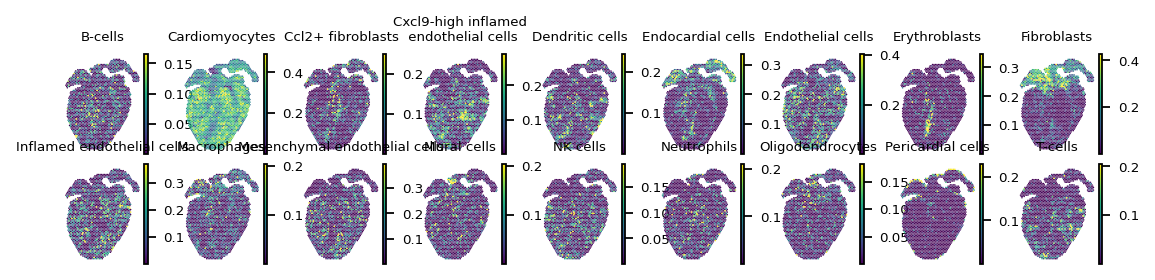

In [138]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=6, figsize=(0.8,0.8), facecolor='white', frameon=True, transparent=True, format="pdf")
sc.pl.spatial(T1L_heart_D7PI_visium_no_viral_genes, color=T1L_heart_D7PI_visium_no_viral_genes.obsm["proportions"].columns, ncols=9, frameon=False, 
              size=1.5, scale_factor=1.0, hspace=0.1, wspace=0.15, save="cell_comp_t1l_d7pi.pdf")

In [4]:
T1L_heart_D7PI_visium_no_viral_genes.obsm['proportions'].columns

Index(['B-cells', 'Cardiomyocytes', 'Ccl2+ fibroblasts',
       'Cxcl9-high inflamed\n endothelial cells', 'Dendritic cells',
       'Endocardial cells', 'Endothelial cells', 'Erythroblasts',
       'Fibroblasts', 'Inflamed endothelial cells', 'Macrophages',
       'Mesenchymal endothelial cells', 'Mural cells', 'NK cells',
       'Neutrophils', 'Oligodendrocytes', 'Pericardial cells', 'T-cells'],
      dtype='object')

In [5]:
celltype_corr = T1L_heart_D7PI_visium_no_viral_genes.obs[T1L_heart_D7PI_visium_no_viral_genes.obsm['proportions'].columns].corr()

/home/mm2937/miniconda3/envs/python385/lib/python3.8/site-packages/seaborn/matrix.py:1216: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


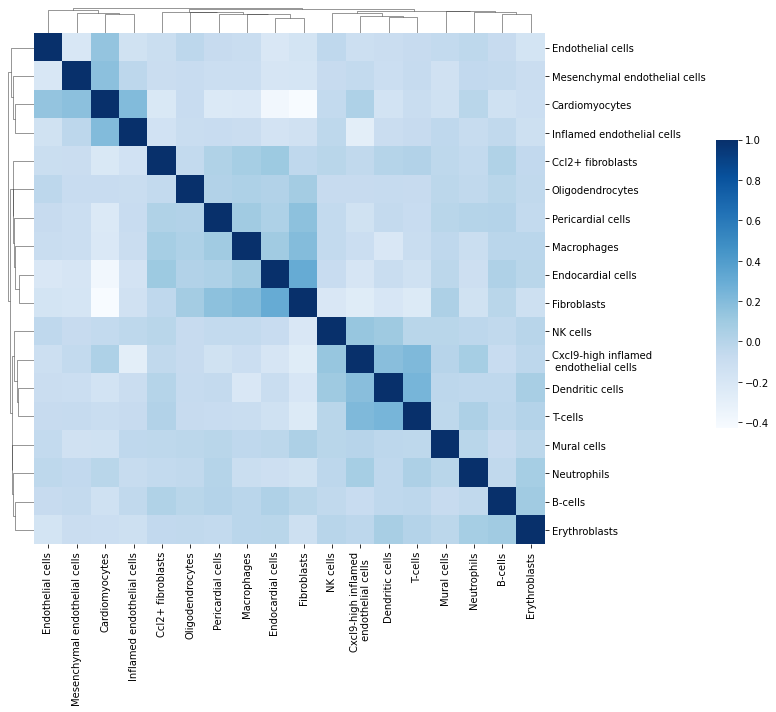

In [8]:
g = sns.clustermap(celltype_corr, square=True, row_cluster=True, dendrogram_ratio=0.05, cbar_pos=(1, 0.4, .03, .4), cmap = "Blues", figsize = (10,10))
g.savefig("figures/coor_heatmap.pdf", facecolor='w', edgecolor='w',
        orientation='potrait', format="pdf",
        transparent=True)

In [9]:
T1L_heart_D7PI_visium_no_viral_genes.obsm["proportions"].describe()

B-cells  Cardiomyocytes  Ccl2+ fibroblasts  \
count  2278.000000    2.278000e+03        2278.000000   
mean      0.027961    2.751132e-01           0.033977   
std       0.041154    9.615269e-02           0.056302   
min       0.000001    5.495506e-07           0.000001   
25%       0.000007    2.100418e-01           0.000007   
50%       0.004780    2.778435e-01           0.000067   
75%       0.044122    3.429235e-01           0.053653   
max       0.440351    5.899657e-01           0.533724   

       Cxcl9-high inflamed\n endothelial cells  Dendritic cells  \
count                              2278.000000     2.278000e+03   
mean                                  0.057897     3.897898e-02   
std                                   0.075056     5.943520e-02   
min                                   0.000001     8.494778e-07   
25%                                   0.000012     5.693173e-06   
50%                                   0.022642     3.027808e-03   
75%                                   0.098279     5.963350e-02   
max                                   0.389048     5.474260e-01   

       Endocardial cells  Endothelial cells  Erythroblasts  Fibroblasts  \
count        2278.000000        2278.000000    2278.000000  2278.000000   
mean            0.058338           0.089049       0.026080     0.083187   
std             0.081090           0.106322       0.063877     0.110058   
min             0.000001           0.000002       0.000002     0.000001   
25%             0.000006           0.000037       0.000008     0.000009   
50%             0.020589           0.050528       0.000012     0.035210   
75%             0.092368           0.148832       0.016759     0.137841   
max             0.429395           0.544228       0.605143     0.614901   

       Inflamed endothelial cells   Macrophages  \
count                 2278.000000  2.278000e+03   
mean                     0.070809  3.421947e-02   
std                      0.094819  4.564388e-02   
min                      0.000003  7.360053e-07   
25%                      0.000024  5.386682e-06   
50%                      0.017393  1.560900e-02   
75%                      0.118824  5.710270e-02   
max                      0.504743  3.379029e-01   

       Mesenchymal endothelial cells  Mural cells      NK cells  Neutrophils  \
count                    2278.000000  2278.000000  2.278000e+03  2278.000000   
mean                        0.058736     0.026783  2.975868e-02     0.024101   
std                         0.094683     0.046829  4.692882e-02     0.046009   
min                         0.000002     0.000001  9.807771e-07     0.000001   
25%                         0.000018     0.000008  4.433865e-06     0.000005   
50%                         0.000111     0.000055  3.223217e-05     0.000011   
75%                         0.094331     0.039515  4.972690e-02     0.033356   
max                         0.623475     0.432557  3.235871e-01     0.401862   

       Oligodendrocytes  Pericardial cells       T-cells  
count       2278.000000       2.278000e+03  2.278000e+03  
mean           0.023540       1.586218e-02  2.561062e-02  
std            0.041870       4.456812e-02  4.558977e-02  
min            0.000001       6.940797e-07  6.015262e-07  
25%            0.000005       2.437250e-06  3.137736e-06  
50%            0.000023       4.560860e-06  1.054773e-05  
75%            0.035223       7.914279e-03  3.836615e-02  
max            0.649200       5.784089e-01  3.785264e-01

In [10]:
T1L_heart_D7PI_visium_no_viral_genes.obs["regions"] = sc.read_h5ad(filename="./../pyobjs/T1L_heart_D7PI.h5ad").obs["anatomical_regions_leiden_0.8"]
T1L_heart_D7PI_visium_no_viral_genes

AnnData object with n_obs × n_vars = 2278 × 2482
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', '_indices', 'B-cells', 'Cardiomyocytes', 'Ccl2+ fibroblasts', 'Cxcl9-high inflamed\n endothelial cells', 'Dendritic cells', 'Endocardial cells', 'Endothelial cells', 'Erythroblasts', 'Fibroblasts', 'Inflamed endothelial cells', 'Macrophages', 'Mesenchymal endothelial cells', 'Mural cells', 'NK cells', 'Neutrophils', 'Oligodendrocytes', 'Pericardial cells', 'T-cells', 'max_pred', 'max_pred_celltype', 'regions'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '_scvi', 'max_pred_celltype_colors', 'spatial'
    obsm: 'proportions', 'spatial'
    layers: 'counts'

In [11]:
ventricle_only = T1L_heart_D7PI_visium_no_viral_genes[T1L_heart_D7PI_visium_no_viral_genes.obs["regions"].isin(["Inflamed ventricle", "Myocarditic region", "Peripheral tissue"]),:]
ventricle_only.obs["regions"].cat.reorder_categories(new_categories=["Inflamed ventricle", "Peripheral tissue", "Myocarditic region"], inplace = True)

/home/mm2937/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [ ]:
import pickle
with open('anatomical_reions_colors.pickle', 'rb') as handle:
    anatomical_reions_colors = pickle.load(handle)
print(anatomical_reions_colors)
color_p = [anatomical_reions_colors[x] for x in list(ventricle_only.obs["regions"].cat.categories)]
color_p

In [12]:
# ["Cardiomyocytes", "Inflamed endothelial cells", "T-cells", "Dendritic cells", "NK cells", "Cxcl9-high inflamed\n endothelial cells"]
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, frameon=True, figsize=(1.2,0.9), transparent=True, format="pdf")
fig, ax = plt.subplots()
ax.set_axisbelow(True)
sc.pl.violin(ventricle_only, keys=["T-cells"], groupby="regions", rotation=60, size=0.2, show=False, ax = ax, palette = color_p)
plt.xticks([])
plt.tight_layout()
# plt.show()
plt.savefig("figures/tcells_prop_violin.pdf", facecolor='w', edgecolor='w',
        orientation='potrait', format="pdf",
        transparent=True, metadata=None)

NameError: name 'plt' is not defined

In [ ]:
temp = pd.DataFrame(ventricle_only.obs[list(T1L_heart_D7PI_visium_no_viral_genes.obs["max_pred_celltype"].cat.categories)].stack())
temp.rename(columns = {0: "Proportions"}, inplace=True)
temp = temp.reset_index()
temp["regions"] = np.repeat(list(ventricle_only.obs["regions"]),18)
temp["regions"] = temp["regions"].astype("category")
temp["regions"].cat.reorder_categories(new_categories=["Inflamed ventricle", "Peripheral tissue", "Myocarditic region"], inplace = True)
temp